In [1]:
'''
Notebook to debug figure plots, e.g. sampling from memory
'''

import os

import cmws
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from cmws import util
from cmws.examples.scene_understanding import data, render, run
from cmws.examples.scene_understanding import util as scene3d_util 
import seaborn as sns
import numpy as np
from cmws.examples.scene_understanding.plot import *


def importance_sample_memory(
    num_particles, obs, obs_id, generative_model, guide, memory, img_size=256
):
    # modifed from: https://github.com/tuananhle7/continuous_mws/blob/a43dd325e1e2c765d9811773ff5885b6f5f400e4/cmws/examples/timeseries/inference.py#L239
    """
    Args
        num_particles
        num_svi_iterations
        obs [batch_size, num_timesteps]
        obs_id [batch_size]
        generative_model
        guide
        memory
    Returns
        latent
            raw_expression [memory_size, batch_size, max_num_chars]
            eos [memory_size, batch_size, max_num_chars]
            raw_gp_params [memory_size, batch_size, max_num_chars, gp_params_dim]
        log_marginal_joint [memory_size, batch_size]
    """
    # Extract
    batch_size = obs.shape[0]
    memory_size = memory.size
    
    print("sampling discrete")

    # Sample discrete latent
    # [memory_size, batch_size, ...]
    discrete_latent = memory.select(obs_id)
    
    print("computing scores")

    # COMPUTE SCORES s_i = log p(d_i, x) for i  {1, ..., M}
    # [memory_size, batch_size]
    log_marginal_joint = cmws.losses.get_log_marginal_joint(
        generative_model, guide, discrete_latent, obs, num_particles
    )
    
    print("expanding and getting continuous")

    # Sample svi-optimized q(z_c | z_d, x)
    # -- Expand obs
    # [memory_size, batch_size, 3, img_size, img_size]
    obs_expanded = obs[None].expand([memory_size, batch_size, 3, img_size, img_size])
    # -- SVI
    continuous_latent = guide.sample_continuous(obs_expanded, discrete_latent)

    # Combine latents
    latent = discrete_latent[0], discrete_latent[1], continuous_latent

    return latent, log_marginal_joint


In [2]:
experiment_name = "cmws_vs_rws_learnColor"
device = "cpu"
save_dir = f"../save/{experiment_name}"
checkpoint_paths = []
for config_name in sorted(os.listdir(save_dir)):
    checkpoint_paths.append(util.get_checkpoint_path(experiment_name, config_name, -1))
checkpoint_path = 'save/cmws_vs_rws_learnColor/cmws_5_2_0.01_2/checkpoints/latest.pt'#checkpoint_paths[0]
checkpoint_path = f"../{checkpoint_path}"
model, optimizer, stats, run_args = scene3d_util.load_checkpoint(
                            checkpoint_path, device="cpu"
                        )
generative_model, guide = model["generative_model"], model["guide"]
num_iterations = len(stats.losses) # note: can use to filter out jobs!
save_dir = util.get_save_dir(run_args.experiment_name, run.get_config_name(run_args))

# Plot stats
plot_stats(f"{save_dir}/stats.png", stats)

# Plot reconstructions and other things
# Test data
# NOTE: Plotting the train dataset only
train_dataset = data.SceneUnderstandingDataset(
    device, run_args.num_grid_rows, run_args.num_grid_cols, test=False,
    remove_color=(run_args.remove_color == 1),
    mode=run_args.mode
)
obs, obs_id = train_dataset[:10]


color status:  False
path:  /om/user/katiemc/continuous_mws/cmws/examples/scene_understanding/data/1_1/cube_0.01/train.pt
19:20:56 | /om/user/katiemc/continuous_mws/cmws/examples/scene_understanding/data.py:348 | INFO: Loading dataset (test = False)...
19:20:56 | /om/user/katiemc/continuous_mws/cmws/examples/scene_understanding/data.py:352 | INFO: Dataset (test = False) loaded /om/user/katiemc/continuous_mws/cmws/examples/scene_understanding/data/1_1/cube_0.01/train.pt
19:20:56 | /om/user/katiemc/continuous_mws/cmws/memory.py:20 | INFO: Initializing memory


100%|██████████| 100/100 [00:00<00:00, 571.75it/s]


19:20:57 | /om/user/katiemc/continuous_mws/cmws/util.py:293 | INFO: Saved to save/cmws_vs_rws_learnColor/cmws_5_2_0.01_2/stats.png
color status:  False
path:  /om/user/katiemc/continuous_mws/cmws/examples/scene_understanding/data/2_2/cube_0.01/train.pt
19:20:57 | /om/user/katiemc/continuous_mws/cmws/examples/scene_understanding/data.py:348 | INFO: Loading dataset (test = False)...
19:20:58 | /om/user/katiemc/continuous_mws/cmws/examples/scene_understanding/data.py:352 | INFO: Dataset (test = False) loaded /om/user/katiemc/continuous_mws/cmws/examples/scene_understanding/data/2_2/cube_0.01/train.pt


In [3]:
memory = model["memory"]

In [4]:
obs = obs.squeeze(1)
num_test_obs, num_channels, im_size, _ = obs.shape
im_size = 128
num_samples = 1

num_particles = memory.size
latent, log_weight = importance_sample_memory(
    num_particles, obs, obs_id, generative_model, guide, memory, im_size
)

num_blocks, stacking_program, raw_locations = latent

# Sort by log weight
# [num_test_obs, num_particles], [num_test_obs, num_particles]
_, sorted_indices = torch.sort(log_weight.T, descending=True)

# Sample predictions
# -- Expand obs
obs_expanded = obs[None].expand(num_particles, num_test_obs, 3, im_size, im_size)

sampling discrete
computing scores
raw locations OBS:  torch.Size([5, 5, 10, 2, 2, 3])
SIZES:  torch.Size([250, 4, 3])
expanding and getting continuous


In [5]:
# # -- Sample predictions
# obs_predictions = generative_model.sample_obs_predictions(latent, obs_expanded, [num_samples])
# predictive_dist = generative_model.get_predictive_dist(latent, obs_expanded)
# predictive_mean = predictive_dist.loc
# predictive_std = predictive_dist.covariance_matrix.diagonal(dim1=-2, dim2=-1).sqrt()
# predictive_low = predictive_mean - 2 * predictive_std
# predictive_high = predictive_mean + 2 * predictive_std

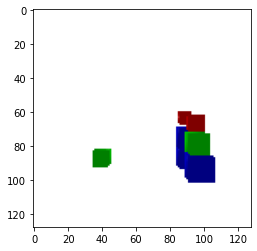

In [6]:
test_obs_id = 3
particle_id = 0 

sorted_particle_id = sorted_indices[test_obs_id, particle_id]

num_blocks_selected = num_blocks[sorted_particle_id, test_obs_id]
stacking_program_selected = stacking_program[sorted_particle_id, test_obs_id]
raw_locations_selected = raw_locations[sorted_particle_id, test_obs_id]

img = obs_expanded[0][test_obs_id].permute(1,2,0)
plt.imshow(img)

In [7]:
# yellow_multiplier = [0.5, 0.5, 0]
# plt.imshow(img * yellow_multiplier)

raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])


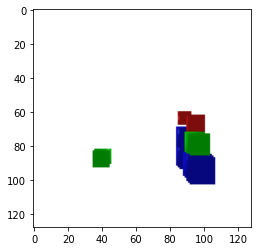

In [8]:
sampled_latent = (num_blocks_selected, stacking_program_selected, raw_locations_selected)
sampled_obs = generative_model.get_obs_loc(sampled_latent)

img = sampled_obs.permute(1,2,0).detach().numpy()
plt.imshow(img)

In [9]:
obs_expanded.shape

torch.Size([5, 10, 3, 128, 128])

In [10]:
log_weight.T

tensor([[-45290.4219, -45289.4766, -45250.1719, -45248.9648, -45201.6836],
        [-45258.4609, -45256.6484, -45253.2070, -45235.2969, -45219.8320],
        [-45276.3750, -45268.0859, -45262.3242, -45243.8633, -45208.4766],
        [-45270.7734, -45271.1562, -45264.5469, -45262.3320, -45217.9688],
        [-45285.4180, -45279.0469, -45258.2578, -45250.9023, -45218.2031],
        [-45271.5312, -45264.7109, -45269.1328, -45248.3086, -45240.0273],
        [-45269.3125, -45278.6055, -45262.5938, -45267.2852, -45221.5781],
        [-45265.3125, -45260.0234, -45260.1289, -45244.5195, -45240.6719],
        [-45251.7305, -45241.8125, -45245.2812, -45236.7539, -45213.8242],
        [-45238.7305, -45237.6758, -45227.3750, -45207.3867, -45207.4180]],
       grad_fn=<PermuteBackward>)

In [11]:
log_weight.T[0][0].item() < log_weight.T[0][1].item()

True

In [12]:
# import matplotlib.gridspec as gridspec
# text_width = 6.75
# column_width = 6.5 / 2.
# text_height = 9.
# golden = (1 + 5 ** 0.5) / 2 # golden ratio

# rows = 4
# cols = 3#5

# # for the samples from memory
# views = [-40, 40] # azimuths
# num_views = len(views)
# num_samples = 3 

# num_primitives = generative_model.num_primitives

# # gridspec inside gridspec
# f = plt.figure(figsize=(8,6), dpi=600)
# # f = plt.figure(figsize=(text_width, rows/cols * text_width), dpi=600)
# gs0 = gridspec.GridSpec(rows, cols, figure=f)

# high_res_img = 256

# generative_model.im_size = high_res_img#512 # change for higher res

# for x in range(rows):
#     if x >= 2: 
#         if x == 3: # show primitives
#             # 1 row, num primitives = num cols
#             print("in grid spec")
#             gs00 = gridspec.GridSpecFromSubplotSpec(1, num_primitives, subplot_spec=gs0[x, 0:],
#                                                wspace=0.025, hspace=0)
#             # Init
#             location = torch.tensor([0, 0, -1], device=device).float()
#             for i in range(num_primitives): 
#                 print("primitive: ", i)
#                 ax = f.add_subplot(gs00[0, i])
#                 obs = render.render_block(
#                     generative_model.primitives[i].size,
#                     generative_model.primitives[i].color,
#                     location,
#                     im_size=high_res_img,
#                     remove_color=False,
#                     mode="cube",
# #                     camera_elevation=30,
# #                     camera_azimuth=40
#                 )
#                 ax.imshow(obs.detach().numpy())
#                 print("created image: ", obs.shape)
#                 ax.set_xticks([])
#                 ax.set_yticks([])
#                 if i == 0: # middle entry
#                     ax.set_ylabel(f'Primitives', fontsize=10, fontfamily='serif')
#             continue # skip the inner loop of cols 
#         else: continue 
#     for y in range(cols):
#         test_obs_id = y 
#         if x == 0: # observations 
#             ax = f.add_subplot(gs0[x, y])
#             img = obs_expanded[0][test_obs_id].permute(1,2,0)
#             ax.imshow(img)
#             ax.set_xticks([])
#             ax.set_yticks([])
#             if y == 0: # middle entry
#                 ax.set_ylabel(f'Observations', fontsize=10)#, fontfamily='serif')
#         else: 
#             gs00 = gridspec.GridSpecFromSubplotSpec(num_samples, num_views, subplot_spec=gs0[x:-1, y],
#                                                wspace=-0.5, hspace=0.0)#wspace=0.025, hspace=0.0)
#             for xx in range(num_samples): 
#                 for yy in range(num_views): 
#                     print("yy: ", yy)
#                     ax = f.add_subplot(gs00[xx, yy])
                    
#                     particle_id = xx
#                     sorted_particle_id = sorted_indices[test_obs_id, particle_id]

#                     num_blocks_selected = num_blocks[sorted_particle_id, test_obs_id]
#                     stacking_program_selected = stacking_program[sorted_particle_id, test_obs_id]
#                     raw_locations_selected = raw_locations[sorted_particle_id, test_obs_id]

#                     sampled_latent = (num_blocks_selected, stacking_program_selected, raw_locations_selected)

#                     camera_elevation = 30
#                     camera_azimuth = views[yy]

#                     sampled_obs = generative_model.get_obs_loc(sampled_latent, (camera_elevation, camera_azimuth))

#                     img = sampled_obs.permute(1,2,0).detach().numpy()
#                     ax.imshow(img)
#                     ax.set_xticks([])
#                     ax.set_yticks([])
#                     if y == 0 and yy == 0 and xx == 1: # middle entry
#                         print("adding title!")
#                         ax.set_ylabel(f'Posterior Samples', fontsize=10, fontfamily='serif')

# path = "learnColor_samples.pdf"
# util.save_fig(f, path, dpi=200)



In [13]:
# import matplotlib.gridspec as gridspec
# text_width = 6.75
# column_width = 6.5 / 2.
# text_height = 9.
# golden = (1 + 5 ** 0.5) / 2 # golden ratio

# rows = 7
# cols = 3#5

# # for the samples from memory
# views = [-40, 40] # azimuths
# num_views = len(views)
# num_samples = 3 

# example_idxs = [0, 1,2]

# num_primitives = generative_model.num_primitives

# # gridspec inside gridspec
# f = plt.figure(figsize=(6,6), dpi=600)
# # f = plt.figure(figsize=(text_width, rows/cols * text_width), dpi=600)
# gs0 = gridspec.GridSpec(rows, cols, figure=f)

# high_res_img = 256

# axis_size = 14
# title_size = 20 

# generative_model.im_size = high_res_img#512 # change for higher res

# for x in range(rows):
#     if x == 1: continue 
#     if x >= 3: 
#         if x == rows-1: # show primitives
#             # 1 row, num primitives = num cols
#             gs00 = gridspec.GridSpecFromSubplotSpec(1, num_primitives, subplot_spec=gs0[x, 0:],
#                                                wspace=0.025, hspace=0)
#             # Init
#             location = torch.tensor([0, 0, -1], device=device).float()
#             for i in range(num_primitives): 
#                 ax = f.add_subplot(gs00[0, i])
#                 obs = render.render_block(
#                     generative_model.primitives[i].size,
#                     generative_model.primitives[i].color,
#                     location,
#                     im_size=high_res_img,
#                     remove_color=run_args.remove_color==1,
#                     mode="cube",
#                 )
#                 ax.imshow(obs.detach().numpy())
#                 ax.set_xticks([])
#                 ax.set_yticks([])
#                 if i == 0: # middle entry
#                     ax.set_ylabel(f'Primitives', fontsize=11)
#             continue # skip the inner loop of cols 
#         else: continue 
#     for y in range(cols):
#         test_obs_id = example_idxs[y] 
#         if x == 0: # observations 
#             ax = f.add_subplot(gs0[:2, y])
#             img = obs_expanded[0][test_obs_id].permute(1,2,0)
#             ax.imshow(img)
#             ax.set_xticks([])
#             ax.set_yticks([])
#             if y == 0: # middle entry
#                 ax.set_ylabel(f'Observations', fontsize=axis_size)#, fontfamily='serif')
#             if y == 1: # middle
#                 ax.set_title("Learning Shape and Color", fontsize=title_size,pad=10)
#         else: 
#             gs00 = gridspec.GridSpecFromSubplotSpec(num_samples, num_views, subplot_spec=gs0[x:-1, y],
#                                                wspace=0.0, hspace=0.0)#wspace=0.025, hspace=0.0)
#             for xx in range(num_samples): 
#                 for yy in range(num_views): 
#                     ax = f.add_subplot(gs00[xx, yy])
                    
#                     particle_id = xx
#                     sorted_particle_id = sorted_indices[test_obs_id, particle_id]

#                     num_blocks_selected = num_blocks[sorted_particle_id, test_obs_id]
#                     stacking_program_selected = stacking_program[sorted_particle_id, test_obs_id]
#                     raw_locations_selected = raw_locations[sorted_particle_id, test_obs_id]

#                     sampled_latent = (num_blocks_selected, stacking_program_selected, raw_locations_selected)

#                     camera_elevation = 30
#                     camera_azimuth = views[yy]

#                     sampled_obs = generative_model.get_obs_loc(sampled_latent, (camera_elevation, camera_azimuth))

#                     img = sampled_obs.permute(1,2,0).detach().numpy()
#                     ax.imshow(img)
#                     ax.set_xticks([])
#                     ax.set_yticks([])
#                     if y == 0 and yy == 0 and xx == 1: # middle entry
#                         ax.set_ylabel(f'Posterior Samples', fontsize=axis_size)

# path = "learnColor_samples.pdf"
# util.save_fig(f, path, dpi=200)



In [14]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

text_width = 6.75
column_width = 6.5 / 2.
text_height = 9.
golden = (1 + 5 ** 0.5) / 2 # golden ratio

rows = 7
cols = 3#5

# for the samples from memory
views = [-40, 40] # azimuths
num_views = len(views)
num_samples = 3 

example_idxs = [0, 1,2]

num_primitives = generative_model.num_primitives

# gridspec inside gridspec
f = plt.figure(figsize=(6,6), dpi=600)
# f = plt.figure(figsize=(text_width, rows/cols * text_width), dpi=600)
gs0 = gridspec.GridSpec(rows, cols, figure=f)

high_res_img = 512

axis_size = 14
title_size = 20 

generative_model.im_size = high_res_img#512 # change for higher res

for x in range(rows):
    if x == 1: continue 
    if x >= 3: 
        if x == rows-1: # show primitives
            # 1 row, num primitives = num cols
            gs00 = gridspec.GridSpecFromSubplotSpec(1, num_primitives, subplot_spec=gs0[x, 0:],
                                               wspace=0.025, hspace=0)
            # Init
            location = torch.tensor([0, 0, -1], device=device).float()
            for i in range(num_primitives): 
                ax = f.add_subplot(gs00[0, i])
                obs = render.render_block(
                    generative_model.primitives[i].size,
                    generative_model.primitives[i].color,
                    location,
                    im_size=high_res_img,
                    remove_color=run_args.remove_color==1,
                    mode="cube",
                )
                ax.imshow(obs.detach().numpy())
                ax.set_xticks([])
                ax.set_yticks([])
                if i == 0: # middle entry
                    ax.set_ylabel(f'Primitives', fontsize=11)
                    axins = inset_axes(ax, width="40%", height="30%")#,loc=3)
                    #axins = inset_axes(ax, width=0.2, height=0.15)#width=0.7, height=0.5)#(ax, width=1.3, height=0.9)
                    minimap = plt.imread("../front_camera.png")
                    axins.imshow(minimap)
                    axins.set_xticks([])
                    axins.set_yticks([])
                    axins.axis('off')
            continue # skip the inner loop of cols 
        else: continue 
    for y in range(cols):
        test_obs_id = example_idxs[y] 
        if x == 0: # observations 
            ax = f.add_subplot(gs0[:2, y])
            img = obs_expanded[0][test_obs_id].permute(1,2,0)
            ax.imshow(img)
            ax.set_xticks([])
            ax.set_yticks([])
            if y == 0: # middle entry
                ax.set_ylabel(f'Observations', fontsize=axis_size)#, fontfamily='serif')
                axins = inset_axes(ax, width="40%", height="30%")#(ax, width=1.3, height=0.9)
#                 axins = inset_axes(ax, width=0.4, height=0.3)#(ax, width=1.3, height=0.9)
                minimap = plt.imread("../front_camera.png")
                axins.imshow(minimap)
                axins.set_xticks([])
                axins.set_yticks([])
                axins.axis('off')
            if y == 1: # middle
                ax.set_title("Inferring shape with color", fontsize=title_size,pad=10)
        else: 
            gs00 = gridspec.GridSpecFromSubplotSpec(num_samples, num_views, subplot_spec=gs0[x:-1, y],
                                               wspace=0.0, hspace=0.0)#wspace=0.025, hspace=0.0)
            for xx in range(num_samples): 
                for yy in range(num_views): 
                    ax = f.add_subplot(gs00[xx, yy])
                    
                    particle_id = xx
                    sorted_particle_id = sorted_indices[test_obs_id, particle_id]

                    num_blocks_selected = num_blocks[sorted_particle_id, test_obs_id]
                    stacking_program_selected = stacking_program[sorted_particle_id, test_obs_id]
                    raw_locations_selected = raw_locations[sorted_particle_id, test_obs_id]

                    sampled_latent = (num_blocks_selected, stacking_program_selected, raw_locations_selected)

                    camera_elevation = 30
                    camera_azimuth = views[yy]

                    sampled_obs = generative_model.get_obs_loc(sampled_latent, (camera_elevation, camera_azimuth))

                    img = sampled_obs.permute(1,2,0).detach().numpy()
                    ax.imshow(img)
                    ax.set_xticks([])
                    ax.set_yticks([])
                    if y == 0:
                        if yy == 0:
                            if xx == 0: 
                                axins = inset_axes(ax, width="40%", height="30%")#(ax, width=1.3, height=0.9)
                                minimap = plt.imread("../left_camera.png")
                                axins.imshow(minimap)
                                axins.set_xticks([])
                                axins.set_yticks([])
                                axins.axis('off')
                            if xx == 1: # middle entry
                                ax.set_ylabel(f'Posterior Samples', fontsize=axis_size)
                        if yy == 1 and xx == 0:
                            axins = inset_axes(ax, width="40%", height="30%")#(ax, width=1.3, height=0.9)
                            minimap = plt.imread("../right_camera.png")
                            axins.imshow(minimap)
                            axins.set_xticks([])
                            axins.set_yticks([])
                            axins.axis('off')

path = "learnColor_samples.pdf"
util.save_fig(f, path, dpi=400)



raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1,

/om/user/katiemc/continuous_mws/cmws/util.py:291: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(**tight_layout_kwargs)


19:30:30 | /om/user/katiemc/continuous_mws/cmws/util.py:293 | INFO: Saved to learnColor_samples.pdf


In [15]:
def img_grid(num_rows, num_cols, filename_list, trgt_name, fig_size, col_headers=None,
             wspace=0.05, hspace=0.05, dpi=600, trgt_root_dir='./sample_plots/',
             col_headersize=4):
    '''Plot images on a grid with optional column headers.'''

    fig, axes = plt.subplots(num_rows, num_cols, figsize=fig_size, dpi=dpi)
    for i, (ax, filename) in enumerate(zip(axes.flat, filename_list)):
        if i < num_cols and col_headers:
            ax.set_title(col_headers[i], fontsize=col_headersize, fontfamily='serif', pad=2.)

        if filename is not None:
            img = imageio.imread(filename)
            ax.imshow(img, cmap='gray')
        ax.axis('off')

    plt.close(fig)
    fig.tight_layout()
    fig.subplots_adjust(wspace=wspace, hspace=hspace)

    util.cond_mkdir(os.path.dirname(trgt_root_dir))

    trgt_path = os.path.join(trgt_root_dir, trgt_name)
    print(f"Saving figure {trgt_path}")
    fig.savefig(trgt_path, bbox='tight', bbox_inches='tight', pad_inches=0.)

In [16]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


col_headersize = 11
# inches
text_width = 6.75
column_width = 6.5 / 2.
text_height = 9.
golden = (1 + 5 ** 0.5) / 2 # golden ratio

axis_size = 14
title_size = 20

# select cars + imgs for context views
# all_items = os.listdir(model_sample_dirs[0][0])
# car_id = np.random.choice(all_items, 1)[0]

# for the samples from memory
views = [0, -40, 40] # azimuths
num_views = len(views)
num_samples = 3 

example_idxs = [0, 1,2]

num_primitives = generative_model.num_primitives

high_res_img = 256
generative_model.im_size = high_res_img

# Get the 3 context views
#ctxt_imgs = [os.path.join(specific_views_dir, car_id, "rgb", convert_view2file(idx)) for idx in range(3)]

# Get 3 samples for single, double, and triple views
#view_ids = 0, 1, 2

rows = len(example_idxs) # number of examples 
cols = 2 # observation + hmws 

# gridspec inside gridspec
f = plt.figure(figsize=(text_width, rows/cols * text_width), dpi=600)
gs0 = gridspec.GridSpec(rows, cols, figure=f)

for x in range(rows):
    
    test_obs_id = example_idxs[x]
    
    # Context images
    ax = f.add_subplot(gs0[x, 0])
    if not x: ax.set_title("Observations", fontsize=axis_size, pad=2.)
    img = obs_expanded[0][test_obs_id].permute(1,2,0)
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    if x == 0: 
        #ax.set_ylabel(f'Observations', fontsize=axis_size)#, fontfamily='serif')
        axins = inset_axes(ax, width="40%", height="30%")#(ax, width=1.3, height=0.9)
#                 axins = inset_axes(ax, width=0.4, height=0.3)#(ax, width=1.3, height=0.9)
        minimap = plt.imread("../front_camera.png")
        axins.imshow(minimap)
        axins.set_xticks([])
        axins.set_yticks([])
        axins.axis('off')
    
    for y in range(cols - 1):
        gs00 = gridspec.GridSpecFromSubplotSpec(num_samples, num_views, subplot_spec=gs0[x, y + 1], 
                                                wspace=-0.01, hspace=-0.3)#wspace=0.05, hspace=-0.3)
        # One row per sample
        for xx in range(3):
            # One column per view
            for yy in range(3):
                ax = f.add_subplot(gs00[xx, yy])
                particle_id = xx
                sorted_particle_id = sorted_indices[test_obs_id, particle_id]

                num_blocks_selected = num_blocks[sorted_particle_id, test_obs_id]
                stacking_program_selected = stacking_program[sorted_particle_id, test_obs_id]
                raw_locations_selected = raw_locations[sorted_particle_id, test_obs_id]

                sampled_latent = (num_blocks_selected, stacking_program_selected, raw_locations_selected)

                
                camera_azimuth = views[yy]
                if camera_azimuth == 0: camera_elevation = 0.1 # default
                else: camera_elevation = 30

                sampled_obs = generative_model.get_obs_loc(sampled_latent, (camera_elevation, camera_azimuth))

                img = sampled_obs.permute(1,2,0).detach().numpy()
                ax.imshow(img)
                ax.set_xticks([])
                ax.set_yticks([])

                if not x and not xx and yy == 1: # First outer row, first inner row, center plot
                    ax.set_title("Posterior Samples", fontsize=axis_size, pad=10.)

                if not yy and not y: # Leftmost view of samples
                    ax.set_ylabel(f'Sample {xx+1}', fontsize=10)
                
                if x == 0 and xx == 0: 
                    axins = inset_axes(ax, width="40%", height="30%")#(ax, width=1.3, height=0.9)
                    if yy == 0: minimap = plt.imread("../front_camera.png")
                    elif yy == 1: minimap = plt.imread("../left_camera.png")
                    elif yy == 2: minimap = plt.imread("../right_camera.png")
                    axins.imshow(minimap)
                    axins.set_xticks([])
                    axins.set_yticks([])
                    axins.axis('off')

# 
f.tight_layout()
f.suptitle("Inferring the scene parse with color", fontsize=20)#, pad=10)
path = "learnColor_samples.pdf"
util.save_fig(f, path, dpi=400)
plt.close(f)

raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1,

/home/katiemc/.conda/envs/cmws/lib/python3.7/site-packages/ipykernel_launcher.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/om/user/katiemc/continuous_mws/cmws/util.py:291: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(**tight_layout_kwargs)


19:32:32 | /om/user/katiemc/continuous_mws/cmws/util.py:293 | INFO: Saved to learnColor_samples.pdf


In [20]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


col_headersize = 11
# inches
text_width = 6.75
column_width = 6.5 / 2.
text_height = 9.
golden = (1 + 5 ** 0.5) / 2 # golden ratio

axis_size = 14
title_size = 20

# select cars + imgs for context views
# all_items = os.listdir(model_sample_dirs[0][0])
# car_id = np.random.choice(all_items, 1)[0]

# for the samples from memory
views = [0, -40, 40] # azimuths
num_views = len(views)
num_samples = 3 

example_idxs = [0, 1,2]

num_primitives = generative_model.num_primitives

high_res_img = 256
generative_model.im_size = high_res_img

# Get the 3 context views
#ctxt_imgs = [os.path.join(specific_views_dir, car_id, "rgb", convert_view2file(idx)) for idx in range(3)]

# Get 3 samples for single, double, and triple views
#view_ids = 0, 1, 2

rows = len(example_idxs) # number of examples 
cols = 3 # observation + hmws 

# gridspec inside gridspec
f = plt.figure(figsize=(text_width, (3/2) * text_width), dpi=600)
gs0 = gridspec.GridSpec(rows, cols, figure=f)

for x in range(rows):
    
    test_obs_id = example_idxs[x]
    
    # Context images
    ax = f.add_subplot(gs0[x, 0])
    if not x: ax.set_title("Observations", fontsize=axis_size, pad=10.)
    img = obs_expanded[0][test_obs_id].permute(1,2,0)
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    if x == 0: 
        #ax.set_ylabel(f'Observations', fontsize=axis_size)#, fontfamily='serif')
        axins = inset_axes(ax, width="40%", height="30%")#(ax, width=1.3, height=0.9)
#                 axins = inset_axes(ax, width=0.4, height=0.3)#(ax, width=1.3, height=0.9)
        minimap = plt.imread("../front_camera.png")
        axins.imshow(minimap)
        axins.set_xticks([])
        axins.set_yticks([])
        axins.axis('off')
    
    for y in range(cols - 1):
        if y == 1: continue
        gs00 = gridspec.GridSpecFromSubplotSpec(num_samples, num_views, subplot_spec=gs0[x, y + 1:], 
                                                wspace=-0.57, hspace=0.0)#wspace=0.05, hspace=-0.3)
        # One row per sample
        for xx in range(3):
            # One column per view
            for yy in range(3):
                ax = f.add_subplot(gs00[xx, yy])
                particle_id = xx
                sorted_particle_id = sorted_indices[test_obs_id, particle_id]

                num_blocks_selected = num_blocks[sorted_particle_id, test_obs_id]
                stacking_program_selected = stacking_program[sorted_particle_id, test_obs_id]
                raw_locations_selected = raw_locations[sorted_particle_id, test_obs_id]

                sampled_latent = (num_blocks_selected, stacking_program_selected, raw_locations_selected)

                
                camera_azimuth = views[yy]
                if camera_azimuth == 0: camera_elevation = 0.1 # default
                else: camera_elevation = 30

                sampled_obs = generative_model.get_obs_loc(sampled_latent, (camera_elevation, camera_azimuth))

                img = sampled_obs.permute(1,2,0).detach().numpy()
                ax.imshow(img)
                ax.set_xticks([])
                ax.set_yticks([])

                if not x and not xx and yy == 1: # First outer row, first inner row, center plot
                    ax.set_title("Posterior Samples", fontsize=axis_size, pad=6.)

                if not yy and not y: # Leftmost view of samples
                    ax.set_ylabel(f'Sample {xx+1}', fontsize=10)
                
                if x == 0 and xx == 0: 
                    axins = inset_axes(ax, width="40%", height="30%")#(ax, width=1.3, height=0.9)
                    if yy == 0: minimap = plt.imread("../front_camera.png")
                    elif yy == 1: minimap = plt.imread("../left_camera.png")
                    elif yy == 2: minimap = plt.imread("../right_camera.png")
                    axins.imshow(minimap)
                    axins.set_xticks([])
                    axins.set_yticks([])
                    axins.axis('off')

# 
f.tight_layout()
f.suptitle("Inferring scene parse with color", fontsize=20)#, pad=10)
path = "learnColor_samples.pdf"
util.save_fig(f, path, dpi=400)
plt.close(f)

raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1,

/home/katiemc/.conda/envs/cmws/lib/python3.7/site-packages/ipykernel_launcher.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/om/user/katiemc/continuous_mws/cmws/util.py:291: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(**tight_layout_kwargs)


19:40:25 | /om/user/katiemc/continuous_mws/cmws/util.py:293 | INFO: Saved to learnColor_samples.pdf


In [18]:
y

1

In [19]:
import matplotlib.gridspec as gridspec
text_width = 6.75
column_width = 6.5 / 2.
text_height = 9.
golden = (1 + 5 ** 0.5) / 2 # golden ratio

rows = 4
cols = 3#5

# for the samples from memory
views = [-40, 40] # azimuths
num_views = len(views)
num_samples = 3 

num_primitives = generative_model.num_primitives

domains = ["learnColor", "noColor"]

# gridspec inside gridspec
f = plt.figure(figsize=(len(domains)*8,6), dpi=600)
# f = plt.figure(figsize=(text_width, rows/cols * text_width), dpi=600)

gs = gridspec.GridSpec(1, len(domains), figure=f)
for idx, domain in enumerate(domains): 
    gs0 = gridspec.GridSpecFromSubplotSpec(rows, cols, subplot_spec=gs[0, idx],
                                                   wspace=0.025, hspace=0)

    high_res_img = 32

    generative_model.im_size = high_res_img#512 # change for higher res

    for x in range(rows):
        if x >= 2: 
            if x == 3: # show primitives
                # 1 row, num primitives = num cols
                print("in grid spec")
                gs00 = gridspec.GridSpecFromSubplotSpec(1, num_primitives, subplot_spec=gs0[x, 0:],
                                                   wspace=0.025, hspace=0)
                # Init
                location = torch.tensor([0, 0, -1], device=device).float()
                for i in range(num_primitives): 
                    print("primitive: ", i)
                    ax = f.add_subplot(gs00[0, i])
                    obs = render.render_block(
                        generative_model.primitives[i].size,
                        generative_model.primitives[i].color,
                        location,
                        im_size=high_res_img,
                        remove_color=(domain == "noColor"),
                        mode="cube",
                    )
                    ax.imshow(obs.detach().numpy())
                    print("created image: ", obs.shape)
                    ax.set_xticks([])
                    ax.set_yticks([])
                    if idx == 0 and i == 0: # leftmost column label only
                        ax.set_ylabel(f'Primitives', fontsize=10, fontfamily='serif')
                continue # skip the inner loop of cols 
            else: continue 
        for y in range(cols):
            test_obs_id = y 
            if x == 0: # observations 
                ax = f.add_subplot(gs0[x, y])
                img = obs_expanded[0][test_obs_id].permute(1,2,0)
                ax.imshow(img)
                ax.set_xticks([])
                ax.set_yticks([])
                if y == 0 and idx == 0: # middle entry
                    ax.set_ylabel(f'Observations', fontsize=10, fontfamily='serif')
            else: 
                gs00 = gridspec.GridSpecFromSubplotSpec(num_samples, num_views, subplot_spec=gs0[x:-1, y],
                                                   wspace=-0.5, hspace=0)
                for xx in range(num_samples): 
                    for yy in range(num_views): 
                        print("yy: ", yy)
                        ax = f.add_subplot(gs00[xx, yy])

                        particle_id = xx
                        sorted_particle_id = sorted_indices[test_obs_id, particle_id]

                        num_blocks_selected = num_blocks[sorted_particle_id, test_obs_id]
                        stacking_program_selected = stacking_program[sorted_particle_id, test_obs_id]
                        raw_locations_selected = raw_locations[sorted_particle_id, test_obs_id]

                        sampled_latent = (num_blocks_selected, stacking_program_selected, raw_locations_selected)

                        camera_elevation = 30
                        camera_azimuth = views[yy]

                        sampled_obs = generative_model.get_obs_loc(sampled_latent, (camera_elevation, camera_azimuth))

                        img = sampled_obs.permute(1,2,0).detach().numpy()
                        ax.imshow(img)
                        ax.set_xticks([])
                        ax.set_yticks([])
                        if idx == 0 and y == 0 and yy == 0 and xx == 1: # middle entry (and ensure leftmost column)
                            print("adding title!")
                            ax.set_ylabel(f'Posterior Samples', fontsize=10, fontfamily='serif')

path = "sample_memory_domains.pdf"
util.save_fig(f, path, dpi=200)



yy:  0
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
yy:  1
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
yy:  0
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
adding title!
yy:  1
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
yy:  0
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
yy:  1
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
yy:  0
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
yy:  1
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
yy:  0
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
yy:  1
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
yy:  0
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
yy:  1
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
yy:  0
raw locations OBS:  torch.Size(